# Programming Assignment 2: Classification Task and Performance Evaluation 

## Task 1.
Use images from ALL FOUR classes. Convert the images to grayscale pixel intensity histograms. (These will be the vector representations of the images). This will be your dataset for Part 2. 

In [7]:
from pathlib import Path
import numpy as np
from PIL import Image

def setup_directories(base_directory):
    directories = {
        "base": base_directory,
        "images": base_directory / 'Images',
        "grayscale": base_directory / 'Grayscale',
        "standardized": base_directory / 'Standardized',
        "train": base_directory / 'Train',
        "test": base_directory / 'Test',
    }
    return directories

def process_images_and_save_histogram(image_directory, save_directory, breed_directories):
    total_images = 0
    processed_images = 0

    for breed_directory in breed_directories:
        breed_path = image_directory / breed_directory
        breed_images = list(breed_path.glob("*.jpg"))
        total_images += len(breed_images)

        for image_file in breed_images:
            processed_images += 1
            with Image.open(image_file) as img:
                grayscale_img = img.convert("L")
                histogram = np.array(grayscale_img.histogram()) / (grayscale_img.width * grayscale_img.height)

            breed_save_dir = save_directory / breed_directory
            breed_save_dir.mkdir(parents=True, exist_ok=True)
            np.save(breed_save_dir / f"{image_file.stem}.npy", histogram)

    return total_images, processed_images

directories = setup_directories(Path.cwd())

breed_directories = [
    'n02085782-Japanese_spaniel',
    'n02093428-American_Staffordshire_terrier',
    'n02105056-groenendael',
    'n02113186-Cardigan'
]

breed_labels = ['Japanese Spaniel', 'American Staffordshire Terrier', 'Groenendael', 'Cardigan']

total_images, processed_images = process_images_and_save_histogram(directories['images'], directories['grayscale'],
                                                                   breed_directories)

print("Total images:", total_images)
print("Processed images:", processed_images)


Total images: 696
Processed images: 696


## Task 2. 
Perform standardization on the dataset. ([See Scikit Learn Documentation for Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)) 

In [8]:
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler

def load_histograms(grayscale_directory, breed_directories):
    histograms = []
    file_paths = []
    for breed_directory in breed_directories:
        breed_path = grayscale_directory / breed_directory
        for npy_file in breed_path.glob("*.npy"):
            histograms.append(np.load(npy_file))
            file_paths.append(npy_file)
    return np.array(histograms), file_paths

def standardize_and_save_histograms(histograms, file_paths, save_directory):
    scaler = StandardScaler()
    standardized_histograms = scaler.fit_transform(histograms)

    total_files = len(file_paths)
    for i, file_path in enumerate(file_paths, start=1):
      
        grayscale_relative_path = file_path.relative_to(directories['grayscale'].parent)
        new_relative_path = Path(*grayscale_relative_path.parts[1:])  # skip the 'Grayscale' part
        save_path = save_directory / new_relative_path
        save_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(save_path, standardized_histograms[i - 1])

    print(f"Standardized and saved {total_files} histograms")

histograms, file_paths = load_histograms(directories['grayscale'], breed_directories)
standardize_and_save_histograms(histograms, file_paths, directories['standardized'])


Standardized and saved 696 histograms


## Task 3. 
Split the dataset into a training set and a test set: For each class, perform a training/test split of 80/20. 

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from pathlib import Path

def load_histograms_and_labels(breed_directories, standardized_base_directory):
    histograms, paths, labels = [], [], []
    for breed in breed_directories:
        
        breed_dir = standardized_base_directory / breed
        for npy_file in breed_dir.glob("*.npy"):
            histograms.append(np.load(npy_file))
            paths.append(npy_file)
            labels.append(breed)
    return np.array(histograms), np.array(paths), labels

histograms, paths, labels = load_histograms_and_labels(breed_directories, directories['standardized'])

def stratified_shuffle_split(histograms, labels, test_size=0.2, random_state=42):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(histograms, labels))
    return histograms[train_idx], histograms[test_idx], paths[train_idx], paths[test_idx]

X_train, X_test, paths_train, paths_test = stratified_shuffle_split(histograms, labels)

def store_histograms(destination_directory, histogram_data, file_paths, reference_directory):
    for histogram, file_path in zip(histogram_data, file_paths):
        new_path = destination_directory / file_path.relative_to(reference_directory)
        new_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(new_path, histogram)

store_histograms(directories['train'], X_train, paths_train, directories['standardized'])
store_histograms(directories['test'], X_test, paths_test, directories['standardized'])

print("Histograms stored in 'train' and 'test' directories.")


Histograms stored in 'train' and 'test' directories.


## Task 4. Model Selection
Perform a standard 5-fold cross-validation and a stratified 5-fold cross-validation on
the training set for k-Nearest Neighbor Classifiers such that $k$ = 1, 3, 5, 7, 10, 20.

1. Plot a graph (x-axis: k; y-axis: mean validation/training error (%)) containing four error curves (2 validation error curves and 2 training error curves - label them clearly using a legend to define the curves). Which $k$ has the lowest mean error for each curve? Comment about (1) the model complexity for k-Nearest Neighbor classifier in relation to $k$, and (2) when/whether there is overfitting/underfitting.

2.  Use the $k$ value with the lowest mean validation error for your k-Nearest Neighbor classifier from the stratified 5-fold cross-validation. What is the test error?

K: 1, Standard Validation Error: 0.6510, Stratified Validation Error: 0.6421, Standard Training Error: 0.0000, Stratified Training Error: 0.0000
K: 3, Standard Validation Error: 0.6385, Stratified Validation Error: 0.6475, Standard Training Error: 0.3611, Stratified Training Error: 0.3588
K: 5, Standard Validation Error: 0.6440, Stratified Validation Error: 0.6296, Standard Training Error: 0.4209, Stratified Training Error: 0.4272
K: 7, Standard Validation Error: 0.6116, Stratified Validation Error: 0.6062, Standard Training Error: 0.4600, Stratified Training Error: 0.4514
K: 10, Standard Validation Error: 0.5883, Stratified Validation Error: 0.6099, Standard Training Error: 0.4775, Stratified Training Error: 0.4775
K: 20, Standard Validation Error: 0.5829, Stratified Validation Error: 0.5936, Standard Training Error: 0.5049, Stratified Training Error: 0.5090

Optimal k value from stratified 5-fold cross-validation: 20
Test error using k=20: 0.6000


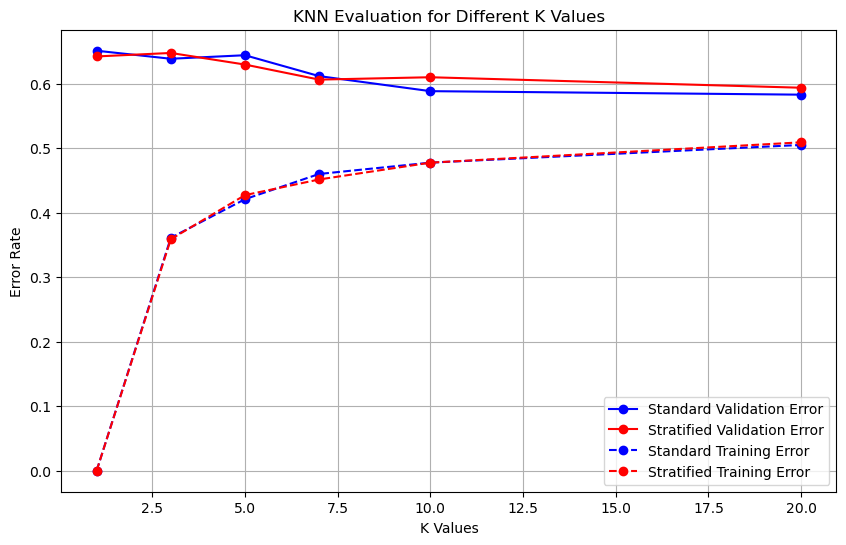

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def load_data_from_npy(breed_dirs, directory):
    data, targets = [], []
    for breed in breed_dirs:
        breed_dir = directory / breed
        for npy_file in breed_dir.glob("*.npy"):
            histogram = np.load(npy_file)
            data.append(histogram)
            targets.append(breed)
    return np.array(data), np.array(targets)

def evaluate_and_plot_knn(X_train, y_train, X_test, y_test):
    k_values = [1, 3, 5, 7, 10, 20]
    results = {
        "k": [],
        "Standard Validation Error": [],
        "Stratified Validation Error": [],
        "Standard Training Error": [],
        "Stratified Training Error": []
    }

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)

    for k in k_values:
        classifier = KNeighborsClassifier(n_neighbors=k)

        standard_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        standard_scores = cross_validate(classifier, X_train, y_train_encoded, cv=standard_cv, return_train_score=True)

        stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        stratified_scores = cross_validate(classifier, X_train, y_train_encoded, cv=stratified_cv,
                                           return_train_score=True)

        for result_name, scores in [("Standard", standard_scores), ("Stratified", stratified_scores)]:
            results[f"{result_name} Validation Error"].append(1 - np.mean(scores['test_score']))
            results[f"{result_name} Training Error"].append(1 - np.mean(scores['train_score']))

        print(f'K: {k}, '
              f'Standard Validation Error: {results["Standard Validation Error"][-1]:.4f}, '
              f'Stratified Validation Error: {results["Stratified Validation Error"][-1]:.4f}, '
              f'Standard Training Error: {results["Standard Training Error"][-1]:.4f}, '
              f'Stratified Training Error: {results["Stratified Training Error"][-1]:.4f}')

    optimal_k = k_values[np.argmin(results["Stratified Validation Error"])]
    print(f"\nOptimal k value from stratified 5-fold cross-validation: {optimal_k}")

    knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k)
    knn_classifier.fit(X_train, y_train_encoded)
    predictions = knn_classifier.predict(X_test)

    test_accuracy = accuracy_score(le.transform(y_test), predictions)
    test_error = 1 - test_accuracy
    print(f"Test error using k={optimal_k}: {test_error:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, results["Standard Validation Error"], marker='o', linestyle='-', color='blue',
             label='Standard Validation Error')
    plt.plot(k_values, results["Stratified Validation Error"], marker='o', linestyle='-', color='red',
             label='Stratified Validation Error')
    plt.plot(k_values, results["Standard Training Error"], marker='o', linestyle='--', color='blue',
             label='Standard Training Error')
    plt.plot(k_values, results["Stratified Training Error"], marker='o', linestyle='--', color='red',
             label='Stratified Training Error')
    plt.xlabel('K Values')
    plt.ylabel('Error Rate')
    plt.title('KNN Evaluation for Different K Values')
    plt.legend()
    plt.grid(True)
    plt.show()

X_train, y_train = load_data_from_npy(breed_directories, directories['train'])
X_test, y_test = load_data_from_npy(breed_directories, directories['test'])

evaluate_and_plot_knn(X_train, y_train, X_test, y_test)


### Results

- **Lowest Mean Error for Each Curve:**
  - Standard Validation: k=3
  - Stratified Validation: k=20
  - Standard Training: k=1
  - Stratified Training: k=1

- *Overfitting/Underfitting:**
   - **Overfitting:** 
      - Observations from the graph: The data shows a high error rate for \(k=1\) in validation, suggesting overfitting at this \(k\) value.
      
   - **Underfitting:** 
      - Observations from the graph: As \(k\) increases, both the training and validation errors seem to converge and plateau. While the error for \(k=20\) isn't the highest, it's worth noting that continually increasing \(k\) beyond this point may lead to underfitting, as the classifier would start to always predict the majority class without considering the more localized patterns.

### 2. Test Error with Optimal \(k\)

- Optimal \(k\) value from stratified 5-fold cross-validation is 20.
- Test error using \(k=20\): 0.6000.

## Task 5: Performance Comparison

Perform stratified 5-fold cross-validation on the 4-class classification problem using the three assigned classification methods:

- Neural Network: `MLPClassifier` with hidden layer sizes of (10, 10, 10) (i.e., 3 hidden layers with 10 nodes each) and default values for the other parameters.
- SVM: `SVC` with default parameters.
- Random Forest: `RandomForestClassifier` with default parameters.

Plot the confusion matrices for the three approaches, clearly labeling the classes, using the test set (see Figure 1). If you use code from any website, please provide proper referencing. Failure to do so will result in 0 points for this assignment

 - Based on the confusion matrix (from the 5-fold cross-validation) for the three methods, which is the best method? Why? 
- Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods. Which is the best method? 
- Compute the accuracies for the three methods on the test set. Which is the best method? 
- Compute the F-measure for the three methods on the test set. Which is the best method? 

Neural Network CV Accuracy: 0.3597
SVM CV Accuracy: 0.4640
Random Forest CV Accuracy: 0.4748


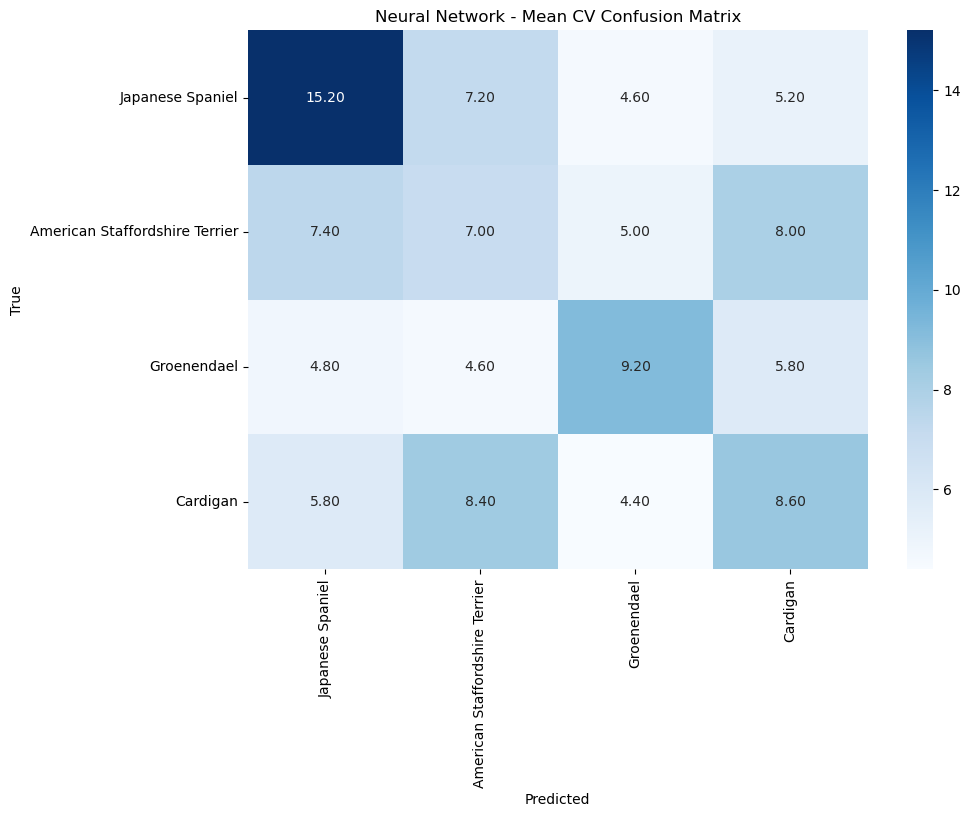

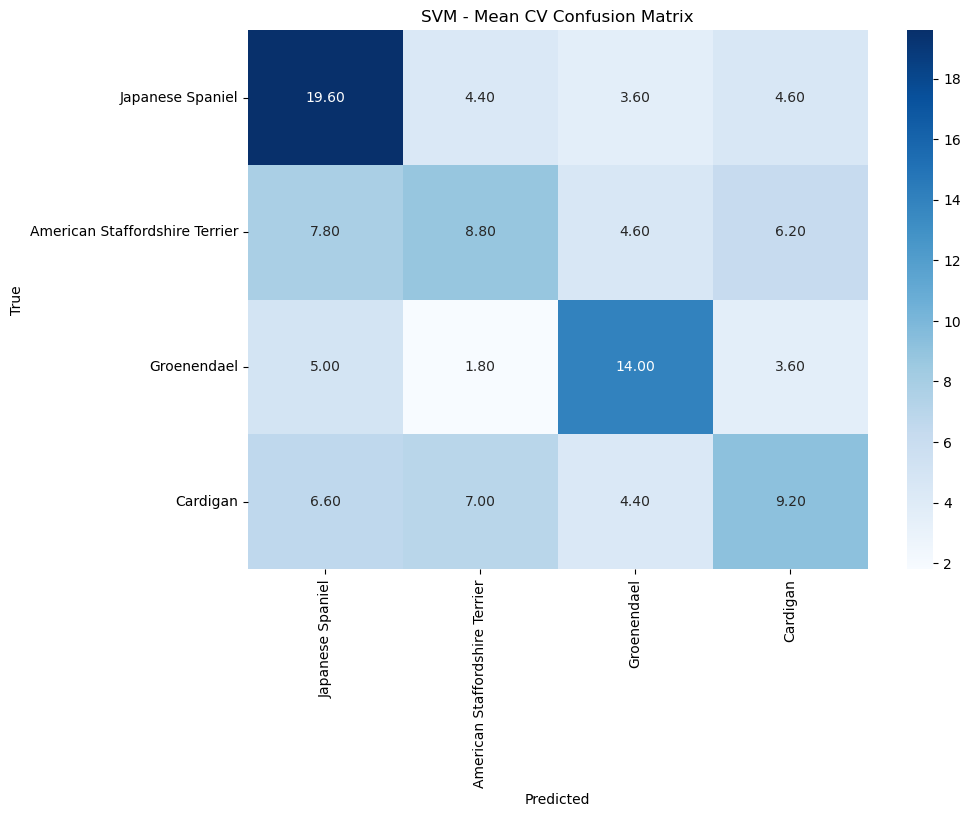

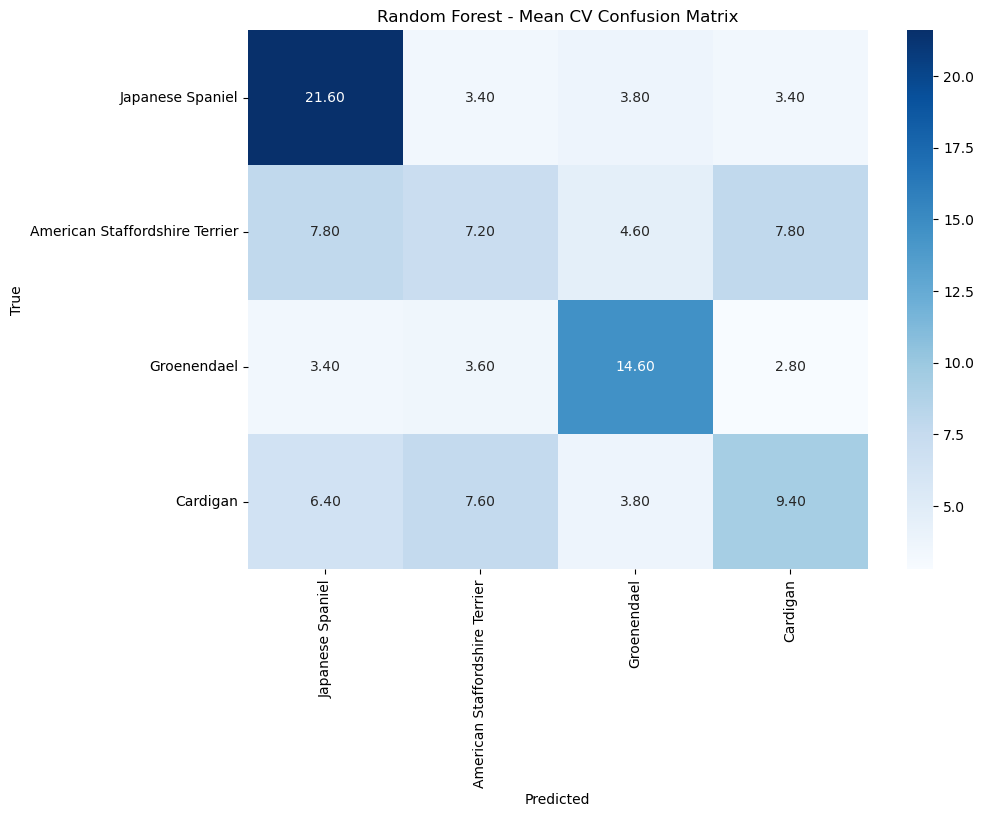

Neural Network Test Accuracy: 0.4143
Neural Network F1 Score: 0.4142
SVM Test Accuracy: 0.4143
SVM F1 Score: 0.4106
Random Forest Test Accuracy: 0.4429
Random Forest F1 Score: 0.4323
Best Test Model: Random Forest with accuracy of 0.4429
Best F1 Model: Random Forest with F1 score of 0.4323


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=ConvergenceWarning)


def load_data(directory_path, breed_directories):
    data, labels = [], []
    for breed_dir in breed_directories:
        full_path = os.path.join(directory_path, breed_dir)
        if not os.path.isdir(full_path):
            print(f"Warning: The directory for {breed_dir} does not exist: {full_path}")
            continue
        for filename in os.listdir(full_path):
            if filename.endswith('.npy'):
                histogram = np.load(os.path.join(full_path, filename))
                data.append(histogram)
                labels.append(breed_dir)
    return np.array(data), np.array(labels)

models = {
    'Neural Network': MLPClassifier(hidden_layer_sizes=(10, 10, 10)),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
}

X_train, y_train = load_data(directories['train'], breed_directories)

cv_confusion_matrices = {}
cv_accuracies = {}
for model_name, model in models.items():
    cv_results = cross_validate(model, X_train, y_train, cv=StratifiedKFold(n_splits=5), return_estimator=True,
                                scoring='accuracy')
    cv_scores = cv_results['test_score']
    cv_accuracies[model_name] = cv_scores.mean()

    confusion_matrices = []
    for estimator, (train_idx, test_idx) in zip(cv_results['estimator'],
                                                StratifiedKFold(n_splits=5).split(X_train, y_train)):
        y_pred = estimator.predict(X_train[test_idx])
        cm = confusion_matrix(y_train[test_idx], y_pred)
        confusion_matrices.append(cm)

    cv_confusion_matrices[model_name] = np.mean(confusion_matrices, axis=0)

    print(f"{model_name} CV Accuracy: {cv_scores.mean():.4f}")

for model_name, conf_matrix in cv_confusion_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=breed_labels, yticklabels=breed_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{model_name} - Mean CV Confusion Matrix")
    plt.show()

X_test, y_test = load_data(directories['test'], breed_directories)

test_results = {}
f1_scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    test_results[model_name] = accuracy
    f1_scores[model_name] = f1

    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"{model_name} F1 Score: {f1:.4f}")

best_test_model = max(test_results, key=test_results.get)
best_f1_model = max(f1_scores, key=f1_scores.get)

print(f"Best Test Model: {best_test_model} with accuracy of {test_results[best_test_model]:.4f}")
print(f"Best F1 Model: {best_f1_model} with F1 score of {f1_scores[best_f1_model]:.4f}")


#### Based on the confusion matrices (on the test set), which do you think is the best method? Why?
- The Neural Network method shows a more consistent distribution of correct predictions across the diagonal. However, SVM seems to have stronger performance for the "Japanese Spaniel" class, but lesser for the "Groenendael" class compared to Neural Network. Random Forest has the highest correct predictions for the "Japanese Spaniel" class and "Groenendael" class, with relatively consistent performance across other classes. When looking at the overall sum of diagonal values (correct classifications), Random Forest seems to have the best performance. 
- _Given that `Random Forest` has a higher correct classification for a broader range of classes, it is considered the best performer based on the provided confusion matrices._

#### Cross-Validation Accuracies Evaluation 
- Among the models, the Random Forest has the highest cross-validation accuracy of  0.4748, making it the best method based on cross-validation accuracies.

#### Test Set Accuracies Evaluation 
- The Random Forest model has the highest test accuracy of 0.4429, making it the best method based on test set accuracies.

#### F-measure Evaluation 
- The Random Forest model has the highest F1 score of 0.4323 on the test set, making it the best method based on the F-measure.

## References

-  [Matplotlib documentation on heatmaps](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.imshow.html)
- [Seaborn documentation on heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
- [Scikit-learn documentation on confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
